<a href="https://colab.research.google.com/github/ppkgtmm/emotion/blob/main/emo_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# !pip install -q keras-tuner
# !git clone --branch main https://github.com/ppkgtmm/sentiment.git sentiment

In [4]:
from sentiment.models.utils import read_data
import pandas as pd
import math
import matplotlib.pyplot as plt
import re
import nltk
from unicodedata import normalize
import collections

In [5]:
nltk.download('punkt')
from nltk import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [7]:
cols = ['text', 'target']

In [8]:
data = read_data('/content/drive/MyDrive/emotion/data/emotion_nlp.csv')

In [9]:
data.sample(5)

,text,target
12712,my girlfriend who had spent months abroad brok...,sadness
8307,i thought i would challenge myself i really wa...,joy
5746,i have the dried bladders all ready for a day ...,joy
4891,i feel so sorry for the people affected,sadness
5371,i feel rebellious and think let them do so,anger


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    20000 non-null  object
 1   target  20000 non-null  object
dtypes: object(2)
memory usage: 312.6+ KB


In [11]:
data[['text']].describe().transpose()

,count,unique,top,freq
text,20000,19948,i have had several new members tell me how com...,2


In [13]:
data.groupby('target').count().reset_index()

,target,text
0,anger,2709
1,fear,2373
2,joy,6761
3,love,1641
4,sadness,5797
5,surprise,719


In [14]:
target_dist = data.groupby('target').count().reset_index()
target_dist['proportion'] = target_dist['text'] / sum(list(target_dist['text']))
target_dist

,target,text,proportion
0,anger,2709,0.13545
1,fear,2373,0.11865
2,joy,6761,0.33805
3,love,1641,0.08205
4,sadness,5797,0.28985
5,surprise,719,0.03595


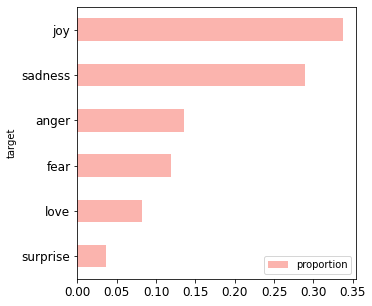

In [16]:
target_dist.sort_values('proportion').plot(x='target', y='proportion', \
                              kind='barh', rot=0, colormap='Pastel1', \
                              fontsize=12, figsize=(5,5))

In [17]:
copy = data.drop_duplicates(subset=cols, keep='last')

In [18]:
dup_counts = copy.groupby('text').nunique('target').reset_index().sort_values('target')

In [19]:
dup_counts[dup_counts['target'] > 1].shape

(51, 2)

In [20]:
copy['word_count'] = copy['text'].apply(lambda x: len(x.split(' ')))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [21]:
def avg_word_length(text):
    words = text.split(' ')
    length = [len(w) for w in words]
    return math.ceil(sum(length) / len(length))

copy['avg_word_length'] = copy['text'].apply(avg_word_length)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [22]:
copy.head(5)

,text,target,word_count,avg_word_length
0,i didnt feel humiliated,sadness,4,5
1,i can go from feeling so hopeless to so damned...,sadness,21,5
2,im grabbing a minute to post i feel greedy wrong,anger,10,4
3,i am ever feeling nostalgic about the fireplac...,love,18,5
4,i am feeling grouchy,anger,4,5


In [23]:
copy.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
word_count,19999.0,19.135407,10.972174,2.0,11.0,17.0,25.0,66.0
avg_word_length,19999.0,4.605930,0.648698,3.0,4.0,5.0,5.0,9.0


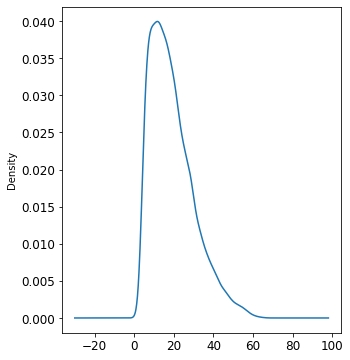

In [24]:
copy.word_count.plot(kind='kde', fontsize=12, figsize=(5,6))

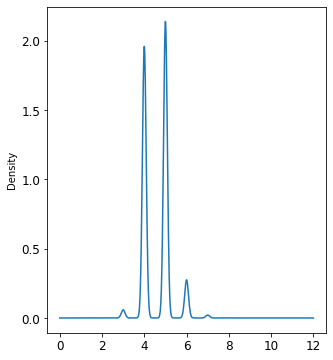

In [25]:
copy.avg_word_length.plot(kind='kde', fontsize=12, figsize=(5,6))

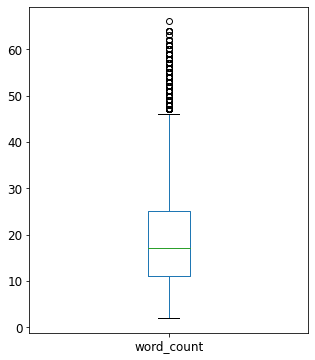

In [26]:
copy.word_count.plot(kind='box', fontsize=12, figsize=(5,6))

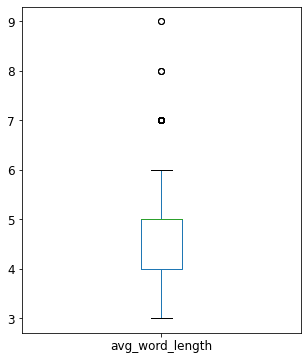

In [27]:
copy.avg_word_length.plot(kind='box', fontsize=12, figsize=(5,6))

In [28]:
word_counts = collections.Counter(" ".join(copy['text']).split())

In [29]:
count_df = pd.DataFrame(word_counts.most_common(20))
count_df.columns = ['word', 'count']
count_df['proportion'] = count_df['count'] / sum(list(count_df['count']))
count_df.head()

,word,count,proportion
0,i,32241,0.223672
1,feel,13937,0.096688
2,and,11996,0.083222
3,to,11207,0.077749
4,the,10462,0.072580


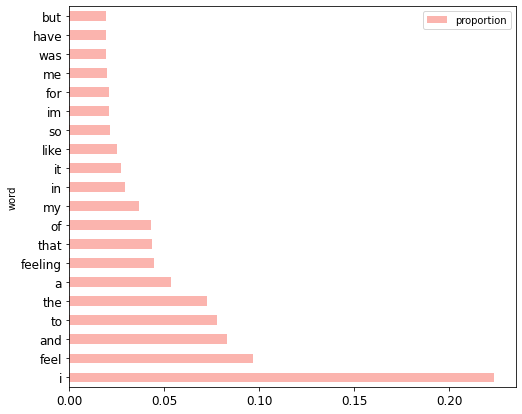

In [30]:
count_df.plot(kind='barh', x='word', y='proportion', rot=0, \
                 colormap='Pastel1', fontsize=12, figsize=(8,7))

In [31]:
reserved_words = ["EMAIL", "NUMBER", "MENTION", "URL"]
token_dict = {
            "ca": "can",
            "wo": "will",
            "sha": "shall",
            "'ve": "have",
            "'ll": "will",
            "'m": "am",
            "n't": "not",
            "'re": "are",
        }
word_dict = {
            "cant": "can not",
            "couldnt": "could not",
            "wont": "will not",
            "pls": "please",
            "plz": "please",
            "youre": "you are",
            "theyre": "they are",
            "ive": "I have",
            "havent": "have not",
            "hasnt": "has not",
            "hadnt": "had not",
            "im": "I am",
            "didnt": "did not",
            "dont": "do not",
            "doesnt": "does not",
            "gotta": "got to",
            "wanna": "want to",
            "gonna": "going to",
            "wannabe": "want to be",
            "cannot": "can not",
        }

In [32]:
def substitute(doc):
        doc = re.sub(r"<br />", " ", doc)
        doc = re.sub(r"\S+@\S+", " EMAIL ", doc)
        doc = re.sub(r"@\S+", " MENTION ", doc)
        doc = re.sub(r"https?:\S+|http?:\S+", " URL ", doc)
        doc = re.sub(r"(\d+\-\d+)|\d+", " NUMBER ", doc)
        doc = re.sub(r"[^A-Za-z']", " ", doc)

        return doc

def expand(token):
        if token in reserved_words:
            return token
        token = token.lower()
        if token.lower().strip() == "let's":
            return "let us"

        if token.lower().strip() == "'twas":
            return "it was"

        if word_dict.get(token, None):
            return word_dict.get(token)

        tokens = word_tokenize(token)
        if len(tokens) == 1:
            return word_dict.get(tokens[0], tokens[0])
        for i in range(len(tokens)):
            tokens[i] = token_dict.get(tokens[i], tokens[i])

        return " ".join(tokens)

def preprocess(doc):
        doc = normalize('NFD',doc).encode('ascii', 'ignore').decode('utf-8')
        doc = substitute(doc)
        tokens = doc.split()
        doc = " ".join([expand(w) for w in tokens])

        tokens = doc.split()
        tokens = [word for word in tokens if word.isalpha()]

        tokens = [
            word.lower() if word not in reserved_words else word for word in tokens
        ]

        return " ".join(tokens)

In [33]:
preprocess("😂 @mama124 Im gonna enter http:bit.ly.12673/ab \
for 30th time :| don't know why cant i České Budějovic á Ś cé")

'MENTION i am going to enter URL for NUMBER th time do not know why can not i ceske budejovic a s ce'

In [34]:
%%time 
copy['text'] = copy['text'].apply(preprocess)

CPU times: user 26.1 s, sys: 14.6 ms, total: 26.1 s
Wall time: 26.1 s


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [35]:
copy.groupby('text')[['target']].count() \
.reset_index().sort_values('target', ascending=False).head(5)

,text,target
15482,i miss our talks our cuddling our kissing and ...,2
17313,i tend to stop breathing when i m feeling stre...,2
4139,i could feel his breath on me and smell the sw...,2
16986,i still feel a craving for sweet food,2
9304,i feel not having a generous spirit or a forgi...,2


In [36]:
duplicates = pd.concat(g for _, g in copy.groupby("text") if len(g) > 1)

In [39]:
duplicates.groupby('text')[['target']] \
.nunique() \
.reset_index() \
.sort_values('target')\
.tail(5)

,text,target
23,i feel on the verge of tears from weariness i ...,2
24,i feel pretty tortured because i work a job an...,2
25,i feel pretty weird blogging about deodorant b...,2
27,i feel so blessed to be a part of your days,2
53,i write these words i feel sweet baby kicks fr...,2


In [41]:
copy.shape

(19999, 4)

In [42]:
copy[['text', 'target']].to_csv('/content/drive/MyDrive/emotion/data/nlp_processed.csv')

In [43]:
word_counts = collections.Counter(" ".join(copy['text']).split())

count_df = pd.DataFrame(word_counts.most_common(20))
count_df.columns = ['word', 'count']
count_df['proportion'] = count_df['count'] / sum(list(count_df['count']))
count_df.head()

,word,count,proportion
0,i,36019,0.235850
1,feel,13937,0.091259
2,and,11996,0.078549
3,to,11287,0.073906
4,the,10462,0.068504


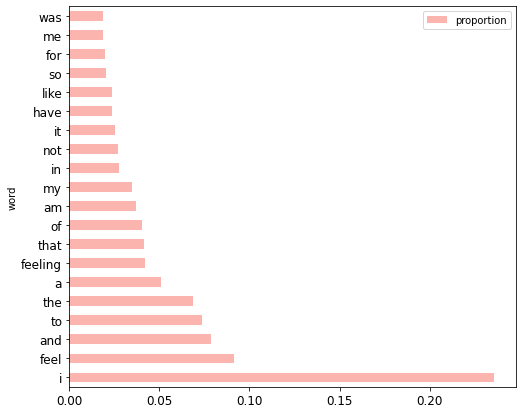

In [44]:
count_df.plot(kind='barh', x='word', y='proportion', rot=0, \
                 colormap='Pastel1', fontsize=12, figsize=(8,7))